In [498]:
%matplotlib inline

In [499]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import obspy
import os
from obspy.taup import TauPyModel
from obspy.geodetics import kilometer2degrees
import copy
import matplotlib
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import shapefile
from fatiando import gridder, utils
import scipy.io
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Coletando os dados das estações BP

In [500]:
ev_list = []
ev_listS = []
for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine_filtered_PP/a_05/'):
#for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/rede_BB/event_data_PP_selected/a_05/'):
    for datafile in files:
        if datafile.endswith('.eqr'):
            ev_list.append(os.path.join(root, datafile))
ev_listS = sorted(ev_list)

In [501]:
ev = obspy.Stream()
for i,j in enumerate(ev_listS):
    ev += obspy.read(j)

In [502]:
event_DD = []
event_MM = []
event_YYYY = []
event_hh = []
event_mm = []
event_julday = []
event_depth = []
event_lat = []
event_long = []
event_dist = []
event_gcarc = []
event_sta = []
event_channel = []
event_ray = []
sta_lat = []
sta_long = []
sta_channel = []
sta_data = []
sta_time = []
event_starttime = []
event_endtime = []


for i,j in enumerate(ev):
    if j.stats.sac.gcarc > 30:
            event_time = (j.stats.starttime)
            event_starttime.append(j.stats.starttime)
            event_endtime.append(j.stats.endtime)
            event_DD.append("{0:02.0f}".format(event_time.day))
            event_MM.append("{0:02.0f}".format(event_time.month))
            event_YYYY.append(event_time.year)
            event_hh.append("{0:02.0f}".format(event_time.hour))
            event_mm.append("{0:02.0f}".format(event_time.minute))
            event_julday.append(event_time.julday)
            event_depth.append(j.stats.sac.evdp/1000)
            event_lat.append(j.stats.sac.evla)
            event_long.append(j.stats.sac.evlo)
            event_dist.append(j.stats.sac.dist)
            event_gcarc.append(j.stats.sac.gcarc)
            event_sta.append(j.stats.station)
            event_ray.append(j.stats.sac.user8)
            sta_lat.append(j.stats.sac.stla)
            sta_long.append(j.stats.sac.stlo)
            sta_data.append(j.data)
            sta_time.append(j.times())

Text(0.5,1,'Events Selected Locataion')

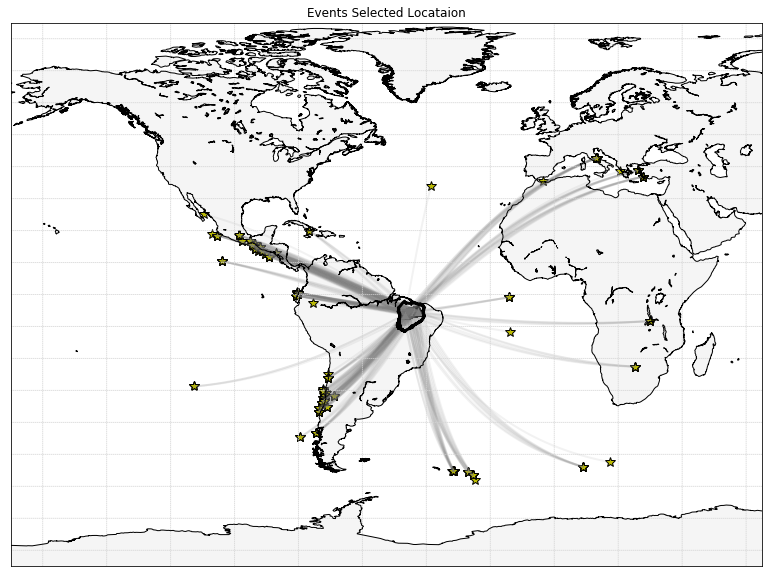

In [503]:
fig=plt.figure(figsize=(20,10))


project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='cyl',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-170.,
            llcrnrlat=-85.,urcrnrlon=65.,urcrnrlat=85.)


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(event_long,event_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '*',markersize=msize,markeredgecolor='k',markerfacecolor='y')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for evlon_0, evlat_0, evlon_c,evlat_c in zip(sta_long,sta_lat,event_long,event_lat):
    m.drawgreatcircle(evlon_0, evlat_0, evlon_c,evlat_c,linewidth=2,color='grey',alpha=0.1)

    
m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='k',zorder=10)
m.drawmeridians(np.arange(0, 360, 20),color='lightgrey')
m.drawparallels(np.arange(-90, 90, 10),color='lightgrey')

sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')

plt.title('Events Selected Locataion')

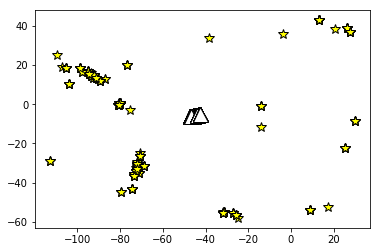

In [504]:
fig, ax = plt.subplots()

for i,j in enumerate(event_lat):
    ax.plot(event_long[i],j, color='yellow', marker='*', markersize=10,markeredgecolor='k') 
    ax.plot(sta_long[i],sta_lat[i], color='w', marker='^', markersize=15,markeredgecolor='k') 

# Calculando os caminhos dos raios para os eventos das estações BP

In [505]:
model = TauPyModel(model="iasp91")

In [506]:
arrivals = []
for i,j in enumerate(event_depth):
    arrivals.append(model.get_ray_paths_geo(
                                    source_depth_in_km=j, source_latitude_in_deg=event_lat[i], 
                                    source_longitude_in_deg=event_long[i], receiver_latitude_in_deg=sta_lat[i], 
                                    receiver_longitude_in_deg=sta_long[i], phase_list=["P"]))

In [507]:
radius = arrivals[0].model.radius_of_planet
camadas = arrivals[0].model.s_mod.v_mod.get_discontinuity_depths()
intp = matplotlib.cbook.simple_linear_interpolation

In [508]:
lat_lst = [[]]*len(arrivals)
long_lst = [[]]*len(arrivals)
depth_lst = [[]]*len(arrivals)
for i,j in enumerate(arrivals):
    lat_lst.append([l.path['lat'] for k,l in enumerate(j)])
    long_lst.append([l.path['lon'] for k,l in enumerate(j)])
    depth_lst.append([l.path['depth'] for k,l in enumerate(j)])

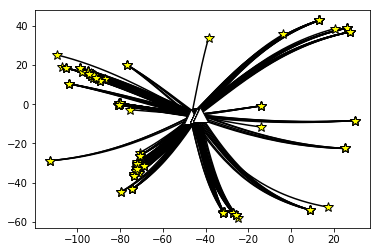

In [509]:
fig, ax = plt.subplots()

for i,j in enumerate(arrivals):
    [ax.plot(l.path['lon'],l.path['lat'],'k-') for k,l in enumerate(j)]
for i,j in enumerate(event_lat):
    ax.plot(event_long[i],j, color='yellow', marker='*', markersize=10,markeredgecolor='k') 
    ax.plot(sta_long[i],sta_lat[i], color='w', marker='^', markersize=15,markeredgecolor='k') 

(-90, 90)

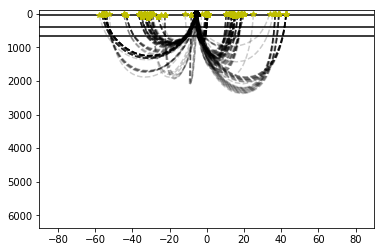

In [510]:
fig, ax = plt.subplots()
for i,j in enumerate(arrivals):
    [ax.plot(l.path['lat'],l.path['depth'],'k--',alpha=0.2) for k,l in enumerate(j)]

for i,j in enumerate(event_depth):
    ax.plot(event_lat[i],j,'y*') 
    ax.plot(sta_lat[i],-10,'k^') 
ax.hlines(410,-90,90)
ax.hlines(40,-90,90)
ax.hlines(660,-90,90)
ax.set_ylim(radius,-100)
ax.set_xlim(-90,90)

In [511]:
event_sta_int = []       
for i,j in enumerate(event_sta):
    if j == 'BDCO':
        event_sta_int.append(0)
    elif j == 'BPPF':
        event_sta_int.append(1)
    elif j == 'BUCO':
        event_sta_int.append(2)
    elif j == 'GENI':
        event_sta_int.append(3)
    elif j == 'GRJU':
        event_sta_int.append(4)
    elif j == 'PRDT':
        event_sta_int.append(5)
    elif j == 'STSN':
        event_sta_int.append(6)
    elif j == 'STSR':
        event_sta_int.append(7)
    elif j == 'TRZN':
        event_sta_int.append(8)        

In [512]:
dist_event = []
depth = []
lat = []
long = []
dist_sta = []


for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        dist_event.append(l.path['dist'][int(len(l.path['dist'])/2):])
        depth.append(l.path['depth'][int(len(l.path['depth'])/2):])
        lat.append(l.path['lat'][int(len(l.path['lat'])/2):])
        long.append(l.path['lon'][int(len(l.path['lon'])/2):])

dist_sta = [[]]*len(dist_event)
for i,j in enumerate(dist_event):
    max_dist = max(j)
    if event_gcarc[i] < 0:
        dist_sta[i] = [abs(max_dist - l) for k,l in enumerate(j)]
    else:
        dist_sta[i] = [abs(max_dist - l)*-1 for k,l in enumerate(j)]

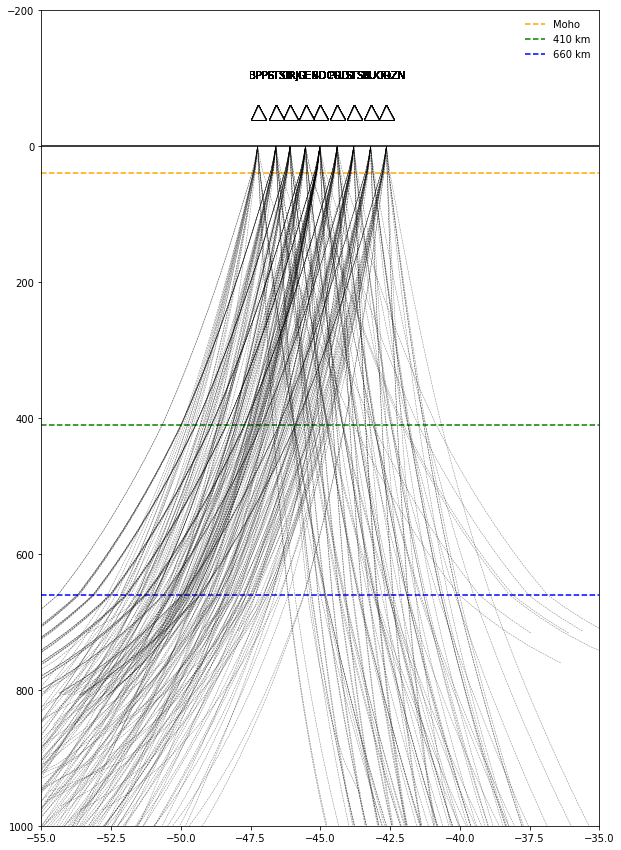

In [513]:
fig, ax = plt.subplots(figsize=(10, 15))



for i,j in enumerate(depth):
        ax.plot(long[i],j,'k--',lw=0.5,alpha=0.5)

#for i,j in enumerate(arrivals):
#    [ax.plot(l.path['dist'],l.path['depth'],'k--',lw=0.5,alpha=0.5) for k,l in enumerate(j)]
#for i,j in enumerate(arrivals):
#    for k,l in enumerate(j):
#        [ax.plot(l.path['long'][x],l.path['depth'][x],marker='+', markersize=2.5,markeredgecolor='orange') for x,c in enumerate(l.path['depth']) if c == 35]
#        [ax.plot(l.path['long'][x],l.path['depth'][x],marker='+', markersize=2.5,markeredgecolor='g') for x,c in enumerate(l.path['depth']) if c == 410]
#        [ax.plot(l.path['long'][x],l.path['depth'][x],marker='+', markersize=2.5,markeredgecolor='b') for x,c in enumerate(l.path['depth']) if c == 660]
for i,j in enumerate(event_depth):
    #ax.plot(event_long[i],j, color='yellow', marker='*', markersize=5,markeredgecolor='k') 
    ax.plot(sta_long[i],-50, color='w', marker='^', markersize=15,markeredgecolor='k')
    ax.text(sta_long[i]-0.3,-100,event_sta[i])

ax.hlines(0,-55,-35,colors='k',linestyles='solid')
ax.hlines(40,-55,-35,colors='orange',linestyles='dashed',label='Moho')
ax.hlines(410,-55,-35,colors='g',linestyles='dashed',label='410 km')
ax.hlines(660,-55,-35,colors='b',linestyles='dashed',label='660 km')

ax.set_ylim(1000,-200)
ax.legend(loc=0,edgecolor='w',fancybox=True)
ax.set_xlim(-55,-35)
fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/ray_path.png',dpi=300)

# Selecionando a profundidade máxima e mínima da migração:

In [514]:
depth_mig_min = 300
depth_mig_max = 700

# Piercing Points - profundidade mínima da migração

In [515]:
pp_depth_mig_min_lat = []
pp_depth_mig_min_long = []
pp_depth_mig_min_time_RF = []
pp_depth_mig_min_depth_RF = []
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        time = l.path['time'][int(len(l.path['time'])/2):]
        time_RF = sorted(abs(max(time) - l.path['time'][int(len(l.path['time'])/2):]))
        depth = l.path['depth'][int(len(l.path['depth'])/2):]
        depth_RF = sorted(depth)
        lat = l.path['lat'][int(len(l.path['lat'])/2):]
        long = l.path['lon'][int(len(l.path['lon'])/2):]

        pp_depth_mig_min_time_RF.append(time_RF)
        pp_depth_mig_min_depth_RF.append(depth_RF)
        
        depth_closest = min(depth, key=lambda x:abs(x-depth_mig_min))
        
        pp_depth_mig_min_lat.append([lat[x] for x,c in enumerate(depth) if c == depth_closest][0])
        pp_depth_mig_min_long.append([long[x] for x,c in enumerate(depth) if c == depth_closest][0])

# Piercing Points - profundidade máxima da migração

In [516]:
pp_depth_mig_max_lat = []
pp_depth_mig_max_long = []
pp_depth_mig_max_time_RF = []
pp_depth_mig_max_depth_RF = []

pp_depth_mig_max_time = []
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        time = l.path['time'][int(len(l.path['time'])/2):]
        time_RF = abs(time[0] - l.path['time'][int(len(l.path['time'])/2):])
        depth = l.path['depth'][int(len(l.path['depth'])/2):]
        depth_RF = depth[::-1]
        lat = l.path['lat'][int(len(l.path['lat'])/2):]
        long = l.path['lon'][int(len(l.path['lon'])/2):]

        pp_depth_mig_max_time_RF.append(time_RF)
        pp_depth_mig_max_depth_RF.append(depth_RF)
        
        depth_closest = min(depth, key=lambda x:abs(x-depth_mig_max))
        
        pp_depth_mig_max_lat.append([lat[x] for x,c in enumerate(depth) if c == depth_closest][0])
        pp_depth_mig_max_long.append([long[x] for x,c in enumerate(depth) if c == depth_closest][0])

In [517]:
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        time = l.path['time'][int(len(l.path['time'])/2):]
        depth = l.path['depth'][int(len(l.path['time'])/2):]
        #depth = depth[::-1]
        #time_RF = time[-1] - l.path['time'][int(len(l.path['time'])/2):]
        #time_RF = time_RF[::-1]

Text(0.5,1.08,'Piercing Points - Filter between 300 km and 700 km')

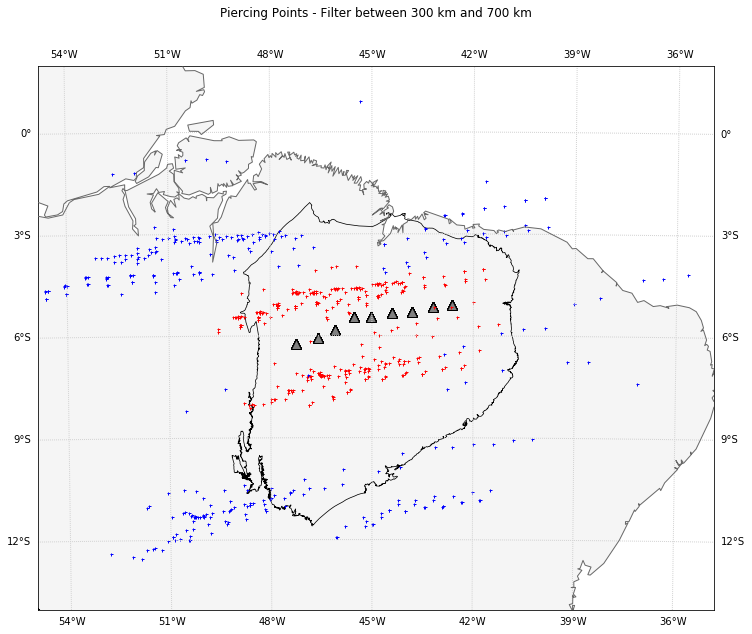

In [518]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='eqdc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-55.,
            llcrnrlat=-14.,urcrnrlon=-35.,urcrnrlat=2.)

sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for lon, lat in zip(pp_depth_mig_min_long,pp_depth_mig_min_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')
    
for lon, lat in zip(pp_depth_mig_max_long,pp_depth_mig_max_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='b',markerfacecolor='k')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 3),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 3),color='lightgrey',labels=[True,True,True,True])


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')

plt.title('Piercing Points - Filter between '+str(depth_mig_min)+' km and '+str(depth_mig_max)+' km', y=1.08)

# Piercing Points - 35 km - MOHO

In [519]:
pp_35_lat = []
pp_35_long = []
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        time = l.path['time'][int(len(l.path['time'])/2):]
        depth = l.path['depth'][int(len(l.path['depth'])/2):]
        lat = l.path['lat'][int(len(l.path['lat'])/2):]
        long = l.path['lon'][int(len(l.path['lon'])/2):]

        pp_35_lat.append([lat[x] for x,c in enumerate(depth) if c == 35][0])
        pp_35_long.append([long[x] for x,c in enumerate(depth) if c == 35][0])

Text(0.5,1.08,'Piercing Points - 40 km')

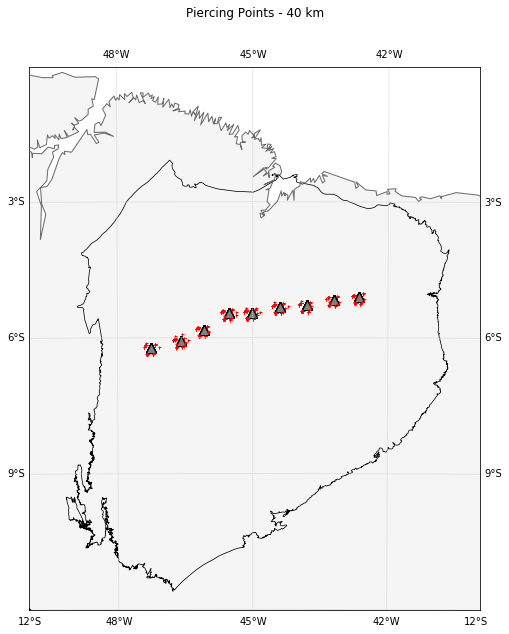

In [520]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='eqdc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-50.,
            llcrnrlat=-12.,urcrnrlon=-40.,urcrnrlat=0.)


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for lon, lat in zip(pp_35_long,pp_35_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 3),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 3),color='lightgrey',labels=[True,True,True,True])


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')

plt.title('Piercing Points - 40 km', y=1.08)

# Piercing Points -410 km

In [521]:
pp_410_lat = []
pp_410_long = []
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        depth = l.path['depth'][int(len(l.path['depth'])/2):]
        lat = l.path['lat'][int(len(l.path['lat'])/2):]
        long = l.path['lon'][int(len(l.path['lon'])/2):]

        pp_410_lat.append([lat[x] for x,c in enumerate(depth) if c == 410][0])
        pp_410_long.append([long[x] for x,c in enumerate(depth) if c == 410][0])

Text(0.5,1.08,'Piercing Points - 410 km')

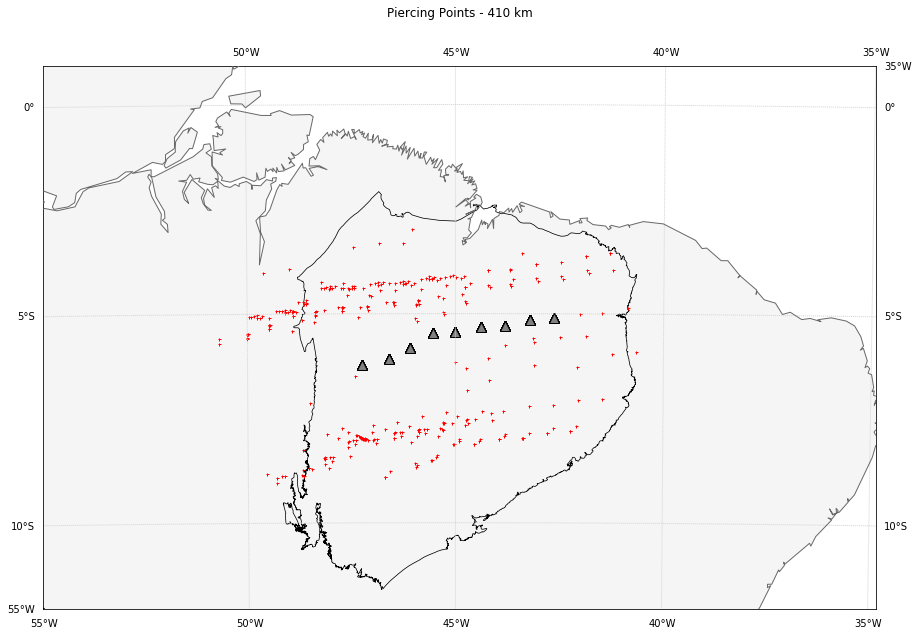

In [522]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='eqdc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-55.,
            llcrnrlat=-12.,urcrnrlon=-35.,urcrnrlat=1.)


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for lon, lat in zip(pp_410_long,pp_410_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')

plt.title('Piercing Points - 410 km', y=1.08)

# Piercing Points -660 km

In [523]:
pp_660_lat = []
pp_660_long = []
for i,j in enumerate(arrivals):
    for k,l in enumerate(j):
        depth = l.path['depth'][int(len(l.path['depth'])/2):]
        lat = l.path['lat'][int(len(l.path['lat'])/2):]
        long = l.path['lon'][int(len(l.path['lon'])/2):]
        for x,c in enumerate(depth):
            if c == 660:
                pp_660_lat.append(lat[x])
                pp_660_long.append(long[x])

Text(0.5,1.08,'Piercing Points - 660 km')

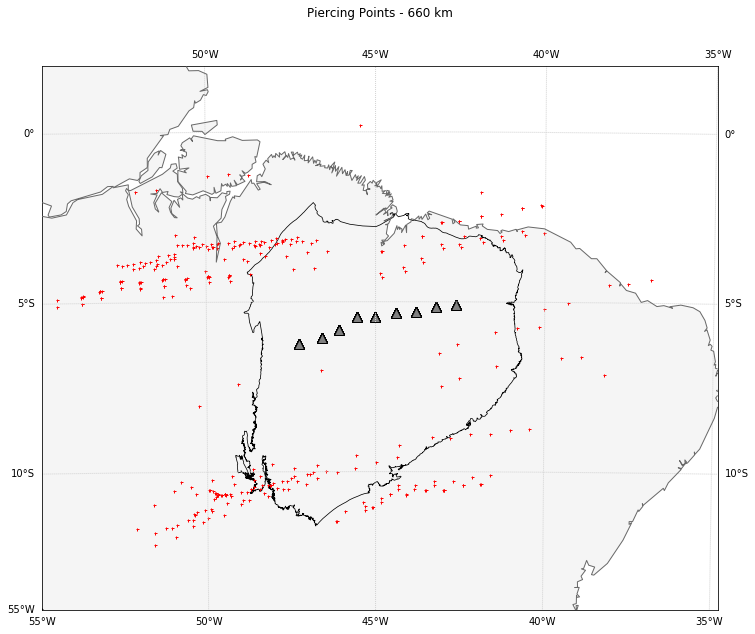

In [524]:
fig=plt.figure(figsize=(20,10))


project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='eqdc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-55.,
            llcrnrlat=-14.,urcrnrlon=-35.,urcrnrlat=2.)


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for lon, lat in zip(pp_660_long,pp_660_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)

        m.plot(x, y, '-', lw=3, color='k')

plt.title('Piercing Points - 660 km', y=1.08)

# Criando o GRID

In [525]:
area_lat = [-15, 0]
area_lon = [-55, -35]

In [526]:
area = (area_lon[0], area_lon[1], area_lat[0], area_lat[1])

shape = (abs(abs(area_lon[1]) - abs(area_lon[0]))*3, abs(abs(area_lat[1]) - abs(area_lat[0]))*3)

# First, we need to know the real data at the grid points
grdx, grdy = gridder.regular(area, shape)

Text(0.5,1.08,'BIN DATA')

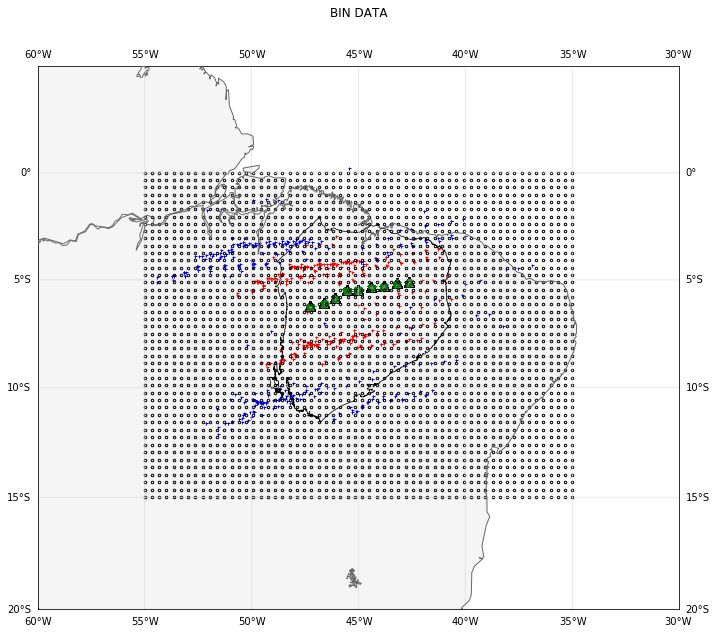

In [527]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-60.,
            llcrnrlat=-20.,urcrnrlon=-30.,urcrnrlat=5.)


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

for lon, lat in zip(pp_35_long,pp_35_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='g',markerfacecolor='k')
    
for lon, lat in zip(pp_410_long,pp_410_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')

for lon, lat in zip(pp_660_long,pp_660_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='b',markerfacecolor='k')
    
for lon, lat in zip(grdx,grdy):
    x,y = m(lon, lat)
    msize = 5
    m.plot(x, y, '.',markersize=msize,markeredgecolor='k',markerfacecolor="None")

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')

plt.title('BIN DATA', y=1.08)

# Filtrando os pontos do GRID

In [528]:
dist_pp_grid_min = [[]]*len(grdx)
for i,j in enumerate(grdx):
    dist_pp_grid_min[i] = [np.sqrt((j - pp_depth_mig_min_long[k])**2 + (grdy[i] - l)**2) for k,l in enumerate(pp_depth_mig_min_lat)]
    
dist_pp_grid_max = [[]]*len(grdx)
for i,j in enumerate(grdx):
    dist_pp_grid_max[i] = [np.sqrt((j - pp_depth_mig_max_long[k])**2 + (grdy[i] - l)**2) for k,l in enumerate(pp_depth_mig_max_lat)]

In [529]:
grid_sel_min = []
grid_sel_min_data = []
for i,j in enumerate(dist_pp_grid_min):
    vect_j = np.array(j) 
    indices = vect_j.argsort()
    if vect_j[indices[2]] < 1.25:
        grid_sel_min.append((grdx[i],grdy[i]))
        
grid_sel_max = []
grid_sel_min_data = []

for i,j in enumerate(dist_pp_grid_max):
    vect_j = np.array(j) 
    indices = vect_j.argsort()
    if vect_j[indices[2]] < 1.25:
        grid_sel_max.append((grdx[i],grdy[i]))


In [530]:
grid_sel = grid_sel_min+grid_sel_max

In [531]:
grid_selected = set(map(tuple,grid_sel))

In [532]:
grid_sel_x = []
grid_sel_y = []
for i,j in enumerate(grid_selected):
    grid_sel_x.append(j[0])
    grid_sel_y.append(j[1])

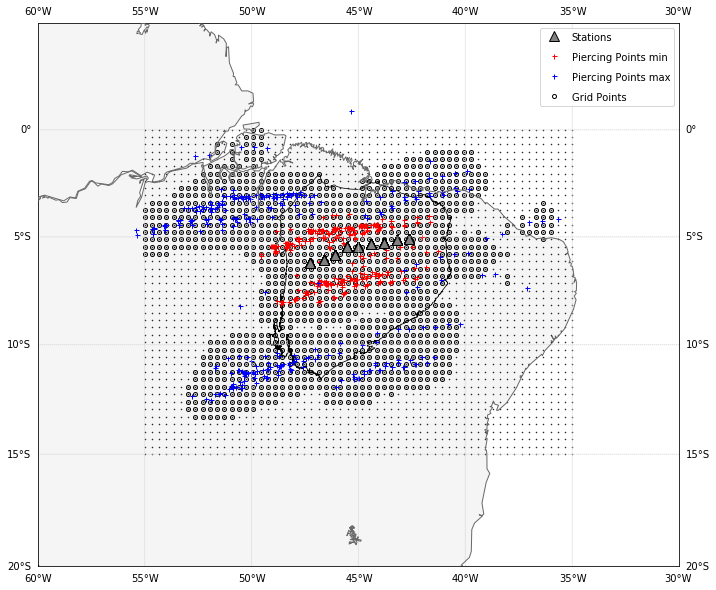

In [533]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-60.,
            llcrnrlat=-20.,urcrnrlon=-30.,urcrnrlat=5.)

sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=0.75, color='k')

for lon, lat in zip(grdx,grdy):
    x,y = m(lon, lat)
    msize = 0.5
    m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor="None")

for lon, lat in zip(grid_sel_x, grid_sel_y):
    x,y = m(lon, lat)
    msize = 4
    l4, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor="None")
    
for lon, lat in zip(pp_depth_mig_min_long,pp_depth_mig_min_lat):
    x,y = m(lon, lat)
    msize = 5
    l2, = m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')
    
for lon, lat in zip(pp_depth_mig_max_long,pp_depth_mig_max_lat):
    x,y = m(lon, lat)
    msize = 5
    l3, = m.plot(x, y, '+',markersize=msize,markeredgecolor='b',markerfacecolor='k')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        x, y = zip(*points)
        m.plot(x, y, '-', lw=3, color='k')
        
label=['Stations','Piercing Points min','Piercing Points max','Grid Points']
plt.legend([l1,l2,l3,l4],label,scatterpoints=1, frameon=True,labelspacing=1, loc='upper right',facecolor='w')

#plt.title('BIN DATA', y=1.08)

In [534]:
RF_data_raw = [[]]*len(grid_sel_x)
RF_RAY_raw = [[]]*len(grid_sel_x)

for i,j in enumerate(grid_sel_x):
    RF_data_raw[i] = [sta_data[k]  for k,l in enumerate(pp_660_lat) if np.sqrt((j - pp_660_long[k])**2 + (grid_sel_y[i] - l)**2) < 1]
    RF_RAY_raw[i] = [event_ray[k]  for k,l in enumerate(pp_660_lat) if np.sqrt((j - pp_660_long[k])**2 + (grid_sel_y[i] - l)**2) < 1]

In [535]:
RF_stacking = []
len_RF_stacking = []
RF_ray_stacking = []

for i,j in enumerate(RF_data_raw):
    if len(j) != 0:
        RF_stacking.append(sum(j)/len(j))
        len_RF_stacking.append(len(j))
        RF_ray_stacking.append(sum(RF_RAY_raw[i])/len(j))
    else:
        RF_stacking.append([])
        len_RF_stacking.append(0)
        RF_ray_stacking.append(0)

Text(0.5,1.08,'BIN DATA')

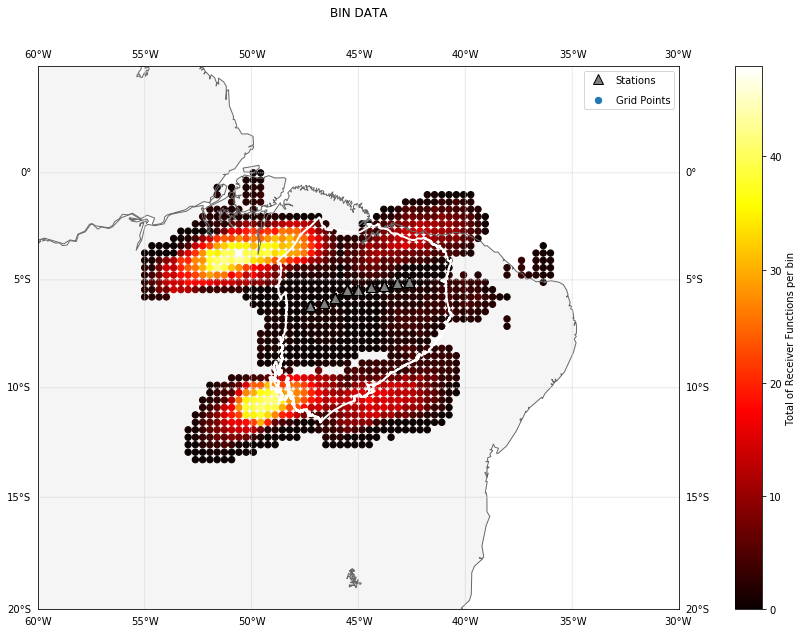

In [536]:
fig=plt.figure(figsize=(20,10))

project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-60.,
            llcrnrlat=-20.,urcrnrlon=-30.,urcrnrlat=5.)

lats = grid_sel_y
lons = grid_sel_x
RF_number = len_RF_stacking
x, y = m(lons,lats)
sc = m.scatter(x,y,40,RF_number,cmap='hot',marker='o')
plt.colorbar(sc,label='Total of Receiver Functions per bin')


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=2, color='w')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color=None,zorder=0)
m.drawcoastlines(color='dimgray',zorder=1)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

plt.legend([l1,sc],['Stations','Grid Points'],scatterpoints=1, frameon=True,labelspacing=1, loc='upper right',facecolor='w')
plt.title('BIN DATA', y=1.08)

# Criando perfis para o GRID

## Perfil A-B

In [537]:
AB_lon_line = [-53,-41]
AB_lat_line = [-11,-11]

In [538]:
AB_lon = np.linspace(AB_lon_line[0],AB_lon_line[1],abs(abs(AB_lon_line[1])-abs(AB_lon_line[0]))*3)
AB_lat = np.linspace(AB_lat_line[0],AB_lat_line[1],abs(abs(AB_lon_line[1])-abs(AB_lon_line[0]))*3)

Text(0.5,1.08,'BIN DATA and Profile')

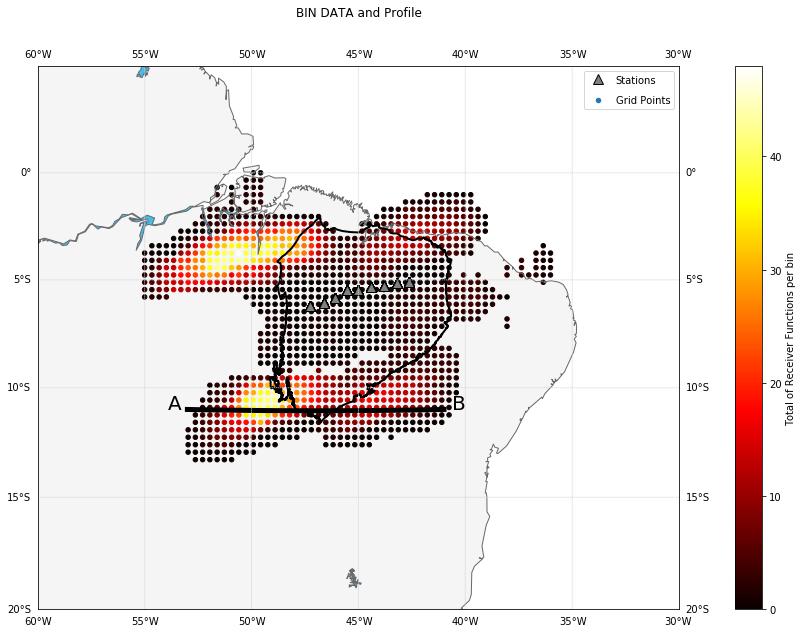

In [539]:
fig=plt.figure(figsize=(20,10))

project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-60.,
            llcrnrlat=-20.,urcrnrlon=-30.,urcrnrlat=5.)

xA, yA = m(AB_lon_line[0],AB_lat_line[0])
plt.text(xA-100000, yA, 'A',fontsize=20)

xB, yB = m(AB_lon_line[1],AB_lat_line[1])
plt.text(xB+40000, yB, 'B',fontsize=20)

m.drawgreatcircle(AB_lon_line[0],AB_lat_line[0],AB_lon_line[1],AB_lat_line[1],linewidth=5,color='k')

for lon, lat in zip(AB_lon,AB_lat):
    x,y = m(lon, lat)
    msize = 10
    #l1, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor='y')

lats = grid_sel_y
lons = grid_sel_x
RF_number = len_RF_stacking
x, y = m(lons,lats)
sc = m.scatter(x,y,20,RF_number,cmap='hot',marker='o')
plt.colorbar(sc,label='Total of Receiver Functions per bin')


sf = shapefile.Reader('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba.shp')
for shape in sf.shapes():
    # adding polygon(s)
    parts = list(shape.parts) + [len(shape.points)]
    partlims = zip(parts[:-1], parts[1:])
    for i1, i2 in partlims:
        points = shape.points[i1:i2]
        lon, lat = zip(*points)
        x,y = m(lon, lat)
        m.plot(x, y, '-', lw=2, color='k')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color='#46bcec',zorder=0)
m.drawcoastlines(color='dimgray',zorder=1)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

plt.legend([l1,sc],['Stations','Grid Points'],scatterpoints=1, frameon=True,labelspacing=1, loc='upper right',facecolor='w')
plt.title('BIN DATA and Profile', y=1.08)

In [540]:
RF_data_profile = []
RF_RAY_profile = []

for i,j in enumerate(AB_lon):
    dist = [np.sqrt((j - grid_sel_x[k])**2 + (AB_lat[i] - l)**2)  for k,l in enumerate(grid_sel_y)]
    RF_data_profile.append(RF_stacking[dist.index(min(dist))])
    RF_RAY_profile.append(RF_ray_stacking[dist.index(min(dist))])

In [541]:
RF_data_profile_stacking = []
RF_RAY_profile_stacking = []
for i,j in enumerate(RF_data_profile):
    if len(j) != 0:
        RF_data_profile_stacking.append(j)
        RF_RAY_profile_stacking.append(RF_RAY_profile[i])

    else:
        RF_data_profile_stacking.append(np.zeros_like(sta_time[0]))
        RF_RAY_profile_stacking.append(0)

In [542]:
Z_real = np.array(RF_data_profile_stacking)

In [543]:
time_real = sta_time[0]

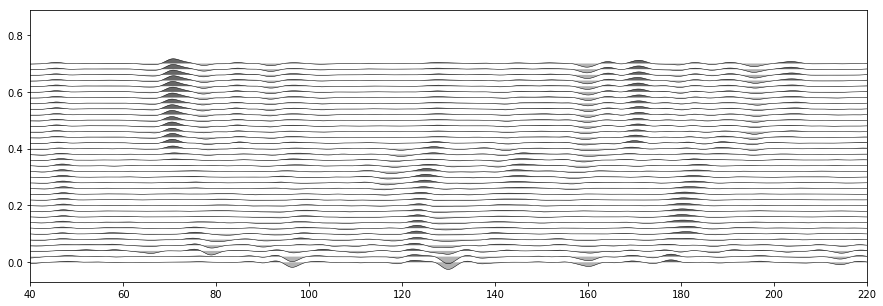

In [544]:
factor = 50
plt.figure(figsize = (15,5))
for i, j in enumerate(RF_data_profile_stacking): 
    plt.plot(time_real-10,i/factor+j,'k',linewidth=0.5)
    plt.fill_between(time_real-10,i/factor+j,i/factor,where=(i/factor+j)>=i/factor, facecolor='black',alpha=0.6, interpolate=True)
    plt.fill_between(time_real-10,i/factor+j,i/factor,where=(i/factor+j)<=i/factor, facecolor='gray',alpha=0.6, interpolate=True)
    #plt.title('Funcoes do Receptor - a = 0.5 - user5 > 80 - '+STA[z])
    plt.xlim(40,220)
    ax.grid(True)

    #plt.ylim(-0.1,0.4)

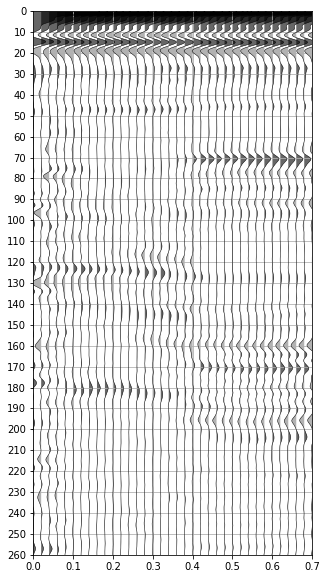

In [545]:
factor = 50
fig, ax = plt.subplots(1, 1, figsize=(5, 10))

#majorLocatorX = MultipleLocator(300)
majorLocatorY = MultipleLocator(10)
minorLocatorY = MultipleLocator(20)
#minorLocatorX = MultipleLocator(10)


for i, j in enumerate(RF_data_profile_stacking): 
    #plt.plot(time_real-10,i/factor+j,'k',linewidth=0.5)
    ax.plot(i/factor+j,time_real-10,'k',linewidth=0.5)
    ax.yaxis.set_major_locator(majorLocatorY)
    #ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.fill_betweenx(time_real-10,i/factor+j,i/factor,where=(i/factor+j)>=i/factor, facecolor='black',alpha=0.6, interpolate=True)
    ax.fill_betweenx(time_real-10,i/factor+j,i/factor,where=(i/factor+j)<=i/factor, facecolor='gray',alpha=0.6, interpolate=True)
    #plt.title('Funcoes do Receptor - a = 0.5 - user5 > 80 - '+STA[z])
    plt.xlim(0,0.7)
    ax.grid(True)

    ax.set_ylim(260,0)

[Text(0,0,'400'),
 Text(0,0,'0'),
 Text(0,0,'10'),
 Text(0,0,'20'),
 Text(0,0,'30'),
 Text(0,0,'40'),
 Text(0,0,'50'),
 Text(0,0,'60'),
 Text(0,0,'70'),
 Text(0,0,'80'),
 Text(0,0,'90'),
 Text(0,0,'100'),
 Text(0,0,'110'),
 Text(0,0,'120'),
 Text(0,0,'130'),
 Text(0,0,'140'),
 Text(0,0,'150'),
 Text(0,0,'160'),
 Text(0,0,'170'),
 Text(0,0,'180')]

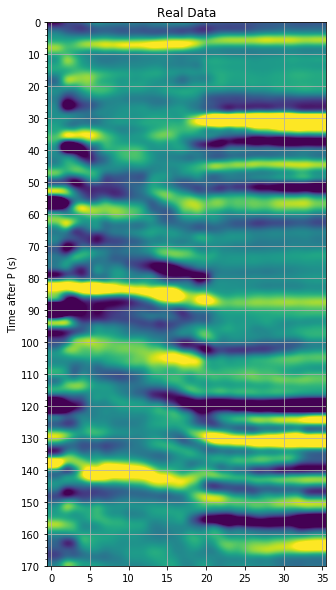

In [546]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))

#majorLocatorX = MultipleLocator(300)
majorLocatorY = MultipleLocator(100)
minorLocatorY = MultipleLocator(20)
#minorLocatorX = MultipleLocator(10)


#Sismograma sem filtro PP
v=0.005
im = ax.imshow(Z_real.T, interpolation='bicubic', cmap=cm.viridis,
                origin='upper', aspect='auto',
                vmax=v, vmin=-v)
                #vmax=abs(Z.min()), vmin=Z.min())
    
ax.set_ylim(2200,500)
#ax.xaxis.set_major_locator(majorLocatorX)
ax.yaxis.set_major_locator(majorLocatorY)
#ax.xaxis.set_minor_locator(minorLocatorX)
ax.yaxis.set_minor_locator(minorLocatorY)
ax.set_ylabel('Time after P (s)')
#ax.set_xlabel('Slowness')
ax.set_title('Real Data')

ax.grid(True)
ax.set_yticklabels(["{0:.0f}".format(time_real[i]) for i in np.arange(-100,len(time_real),100)])
#ax.set_xticklabels(["{0:.1f}".format(RP_real[i]*100) for i in np.arange(0,len(RP_real),100)])
#ax.set_xticklabels(["{0:.1f}".format(GCARC_real[i]) for i in np.arange(0,len(GCARC_real),100)])

# Move-Out  Corrections

### The use of velocity spectrum for stacking receiver functions and  imaging upper mantle discontinuities

##### H. Gurrola, J. B. Minster and T. Owens

##### Geophys. J . In<. (1994) 117,427-440

In [547]:
model_velocity = arrivals[0][0]

In [548]:
radius

6371.0

In [549]:
arrivals[0].model.s_mod.v_mod.get_discontinuity_depths()

array([   0. ,   20. ,   35. ,  210. ,  410. ,  660. , 2889. , 5153.9,
       6371. ])

dtype=[('top_depth', '<f8'), ('bot_depth', '<f8'), ('top_p_velocity', '<f8'), ('bot_p_velocity', '<f8'), ('top_s_velocity', '<f8'), ('bot_s_velocity', '<f8'), ('top_density', '<f8'), ('bot_density', '<f8'), ('top_qp', '<f8'), ('bot_qp', '<f8'), ('top_qs', '<f8'), ('bot_qs', '<f8')])

In [550]:
top_depth = []
bot_depth = []
top_p_velocity = []
bot_p_velocity = []
top_s_velocity = []
bot_s_velocity = []
top_density = []
bot_density = []
top_qp = []
bot_qp = []
top_qs = []
bot_qs = []
for i,j in enumerate(model_velocity.phase.tau_model.s_mod.v_mod.layers):
    top_depth.append(j[0])
    bot_depth.append(j[1])
    top_p_velocity.append(j[2])
    bot_p_velocity.append(j[3])
    top_s_velocity.append(j[4])
    bot_s_velocity.append(j[5])
    top_density.append(j[6])
    bot_density.append(j[7])
    top_qp.append(j[8])
    bot_qp.append(j[9])
    top_qs.append(j[10])
    bot_qs.append(j[11])

(-0.5, 14)

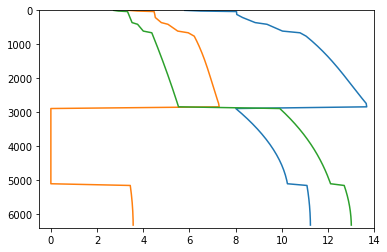

In [551]:
plt.figure()
plt.plot(top_p_velocity,top_depth)
plt.plot(top_s_velocity,top_depth)
plt.plot(top_density,top_depth)
plt.ylim(6400,0)
plt.xlim(-0.5,14)


In [552]:
IASP91_depth = np.arange(0,1005,5)

In [568]:
subtract_IASP01_obspy_model = [[]]*len(IASP91_depth)
for i,j in enumerate(IASP91_depth):
    subtract_IASP01_obspy_model[i] = [abs(j - l) for k,l in enumerate(top_depth)]

In [569]:
IASP01_pvel = []
IASP01_density = []
IASP01_svel = []
for i,j in enumerate(subtract_IASP01_obspy_model):
    IASP01_pvel.append(bot_p_velocity[j.index(min(j))])
    IASP01_svel.append(bot_s_velocity[j.index(min(j))])
    IASP01_density.append(bot_density[j.index(min(j))])

(1000, 0)

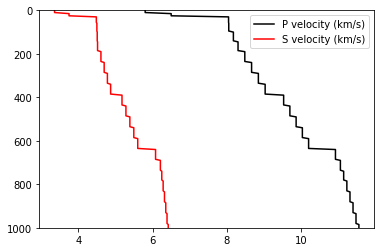

In [570]:
plt.plot(IASP01_pvel,IASP91_depth,'k',label='P velocity (km/s)')
plt.plot(IASP01_svel,IASP91_depth,'r',label='S velocity (km/s)')
plt.legend()
plt.ylim(1000,0)

## Reflection moveout (e.g. Sheriff & Geldart 1982; Yilmaz 1987)

delta_T_Ps0 = z*((np.sqrt(Vs)**-2 - p**2) - ((np.sqrt(Vp)**-2 - p**2)))

In [571]:
delta_T_Ps = [[]]*len(IASP91_depth)
for i,j in enumerate(IASP91_depth):
    delta_T_Ps0 = j*(np.sqrt(np.power(IASP01_svel[i],-2)) - np.sqrt(np.power(IASP01_pvel[i],-2)))
    Rv = IASP01_pvel[i]/IASP01_svel[i]
    delta_T_Ps[i] = [((Rv*delta_T_Ps0)/(Rv-1))*(np.sqrt(1 - np.power(l,2)*np.power(IASP01_svel[i],2)) - np.sqrt(np.power(Rv,-2) - np.power(l,2)*np.power(IASP01_svel[i],2))) for l in RF_RAY_profile_stacking]

(100, 0)

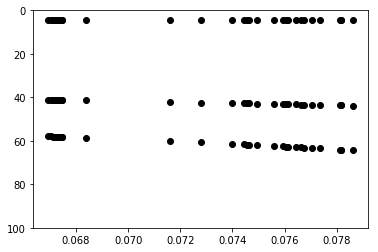

In [572]:
plt.plot(RF_RAY_profile_stacking,delta_T_Ps[8],'ok')
plt.plot(RF_RAY_profile_stacking,delta_T_Ps[82],'ok')
plt.plot(RF_RAY_profile_stacking,delta_T_Ps[132],'ok')

plt.ylim(100,0)


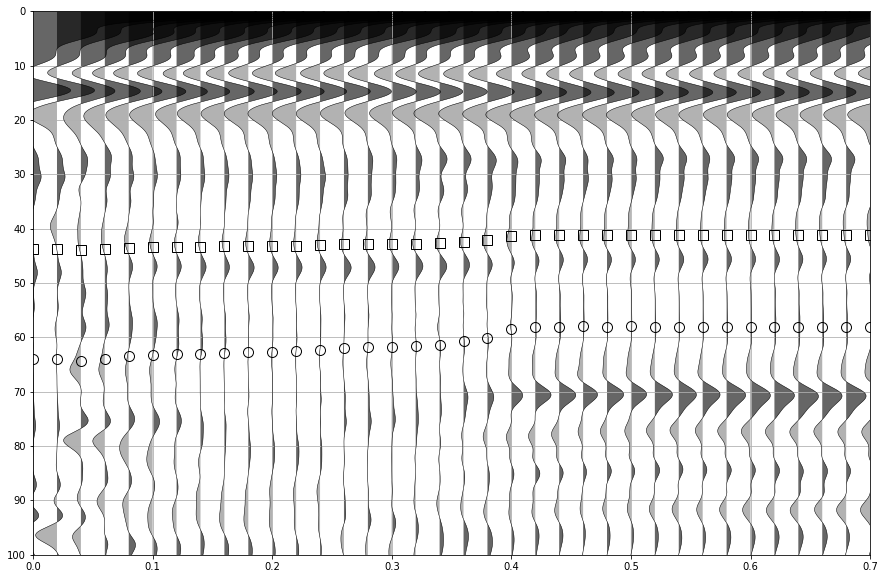

In [573]:
factor = 50
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

#majorLocatorX = MultipleLocator(300)
majorLocatorY = MultipleLocator(10)
minorLocatorY = MultipleLocator(20)
#minorLocatorX = MultipleLocator(10)


for i, j in enumerate(RF_data_profile_stacking): 
    ax.plot(i/factor,delta_T_Ps[82][i],'sk',markersize=10,markeredgecolor='k',markerfacecolor='None')
    ax.plot(i/factor,delta_T_Ps[132][i],'ok',markersize=10,markeredgecolor='k',markerfacecolor='None')
    #plt.plot(time_real-10,i/factor+j,'k',linewidth=0.5)
    ax.plot(i/factor+j,time_real-10,'k',linewidth=0.5)
    ax.yaxis.set_major_locator(majorLocatorY)
    #ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.fill_betweenx(time_real-10,i/factor+j,i/factor,where=(i/factor+j)>=i/factor, facecolor='black',alpha=0.6, interpolate=True)
    ax.fill_betweenx(time_real-10,i/factor+j,i/factor,where=(i/factor+j)<=i/factor, facecolor='gray',alpha=0.6, interpolate=True)
    #plt.title('Funcoes do Receptor - a = 0.5 - user5 > 80 - '+STA[z])
    plt.xlim(0,0.7)
    ax.grid(True)

    ax.set_ylim(100,0)